In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import tqdm
import typing

_ = matplotlib.rc("text", usetex=True)
_ = matplotlib.rc("font", family="serif", serif="CMU Serif")

Below are some helper methods to make processing the data frames a tad easier.

In [3]:
def filter_dataframe(df: pd.DataFrame, **kwargs):
    """Filter the dataframe according to the keyword arguments"""
    filtered_df = df
    for key, value in kwargs.items():
        if not isinstance(value, typing.Union[list, tuple]):
            value = [value]
        filtered_df = filtered_df[filtered_df[key].isin(value)]
    return filtered_df


def get_feature_values(
    df: pd.DataFrame, 
    feature: typing.Union[typing.Iterable, str],
):
    """Identify set of features that the data frame will be partitioned by"""
    match feature:
        case str():
            return sorted([*set(df[feature].tolist())])
        case list() | tuple():
            return feature
        case _:
            return [None]


def get_partial_df(
    df: pd.DataFrame, 
    feature: typing.Union[typing.Iterable, str],
    value: typing.Union[None, str],
):
    """Helper method to identify a subset of the data frame"""
    if value is None or isinstance(value, typing.Union[list, tuple]):
        return df.copy()
    return df[df[feature] == value]


def build_figure(
    nrows: int, 
    ncols: int, 
    row_dim: int = 6, 
    col_dim: int = 2,
    sharex: bool = False,
    sharey: bool = False,
):
    """Generate a plt figure and axes"""
    figsize = (row_dim * nrows, col_dim * ncols)
    fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        sharex=sharex, 
        sharey=sharey, 
        figsize=figsize,
    )
    if nrows == 1:
        axes = [axes]
    if ncols == 1:
        axes = [axes]
    return (fig, axes)


In [25]:
def plot_figure(
    df: pd.DataFrame,
    num_rows: int = 1,
    num_cols: int = 1,
    x_axis: typing.Union[str, list[str]] = "duration_mean",
    y_axis: typing.Union[str, list[str]] = "error",
    x_axis_label: typing.Union[str, list[str]] = "Duration (seconds)",
    y_axis_label: typing.Union[str, list[str]] = "Recall error",
    log_x: bool = False,
    log_y: bool = False,
    share_x: bool = False,
    share_y: bool = False,
    log_x_base: float = 2,
    log_y_base: float = 2,
    line: str = "k_b",
    scatter_only: bool = True,
    fig_dims: tuple[float] = (6, 3),
    filename: str = None,
    color_scheme: str = "blend:#FF6F79,#6FB0FF",
    **kwargs,
) -> None:
    """Plot an arbitrary figure for the paper"""
    df = filter_dataframe(df, **kwargs)



sparq_df = pd.read_json("../data/sparq-data-merged.jsonl", lines=True)
plot_figure(sparq_df)


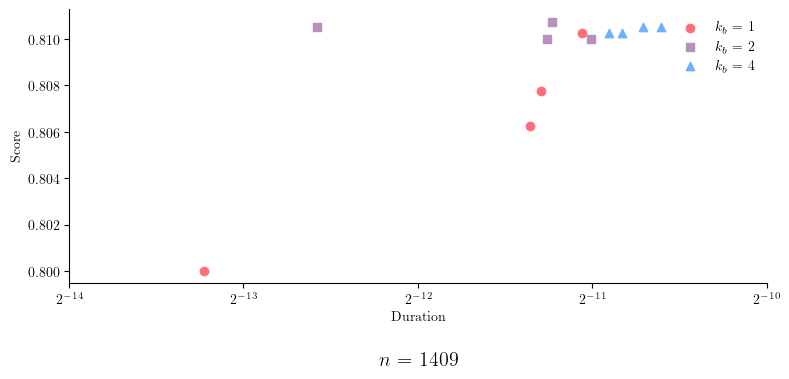

In [32]:
LABELS = {
    "duration_mean": "Duration",
    "recall": "Recall",
    "error": "Recall error",
    "k": r"$k$",
    "n": r"$n$",
    "k_b": r"$k_b$",
    "batch_size": "Batch size",
    "task_name": "Task",
    "n_over_k": r"$n/k$",
    "score": "Score",
}

MARKERS = ["o", "s", "^", "+", "*", "x", "D"]


def plot_tradeoffs(
    df: pd.DataFrame,
    row_feature: typing.Union[typing.Iterable, str] = None,
    col_feature: typing.Union[typing.Iterable, str] = None,
    x_axis_feature: str = "duration_mean",
    y_axis_feature: str = "error",
    line_feature: str = "k_b",
    logx: bool = False,
    logy: bool = False,
    sharex: bool = False,
    sharey: bool = False,
    annotate_rows: bool = True,
    annotate_cols: bool = True,
    row_title_padding: float = 0.1,
    col_title_padding: float = 0.3,
    xbase=2,
    ybase=10,
    scatter_only: bool = False,
    dims: tuple[float] = (6, 3),
    filename: str = None,
    **kwargs,
) -> None:
    """Plot the tradeoff between cost and task performance"""

    df = filter_dataframe(df, **kwargs)
    
    line_features = get_feature_values(df, line_feature)
    row_features = get_feature_values(df, row_feature)
    col_features = get_feature_values(df, col_feature)
    fig, axes = build_figure(
        nrows=len(row_features), 
        ncols=len(col_features), 
        sharex=sharex, 
        sharey=sharey,
        row_dim=dims[0],
        col_dim=dims[1],
    )

    # palette = sns.color_palette("flare", n_colors=len(line_features))
    palette = sns.color_palette("blend:#FF6F79,#6FB0FF", n_colors=len(line_features))

    for row_id, row_value in enumerate(row_features):
        row_df = get_partial_df(df, row_feature, row_value)
        for col_id, col_value in enumerate(col_features):
            ax = axes[row_id][col_id]
            col_df = get_partial_df(row_df, col_feature, col_value)

            if isinstance(row_feature, typing.Union[list, tuple]):
                y_axis_feature = row_feature[row_id]
            if isinstance(col_feature, typing.Union[list, tuple]):
                x_axis_feature = col_feature[col_id]

            line_values = get_feature_values(col_df, line_feature)

            min_x, max_x, min_y, max_y = np.inf, -np.inf, np.inf, -np.inf

            for line_value in line_values:
                line_id = line_features.index(line_value)

                line_df = get_partial_df(col_df, line_feature, line_value)
                line_df = line_df.sort_values(x_axis_feature)
                
                if not scatter_only:
                    ax.plot(
                        line_df[x_axis_feature], 
                        line_df[y_axis_feature],
                        color=palette[line_id],
                    )
                ax.scatter(
                    line_df[x_axis_feature], 
                    line_df[y_axis_feature],
                    color=palette[line_id],
                    label=rf"{LABELS[line_feature]} = {line_value}",
                    marker=MARKERS[line_id],
                )

                min_x = min(min_x, min(line_df[x_axis_feature]))
                min_y = min(min_y, min(line_df[y_axis_feature]))
                max_x = max(max_x, max(line_df[x_axis_feature]))
                max_y = max(max_y, max(line_df[y_axis_feature]))

            if annotate_rows and col_id == 0:
                if y_axis_feature != row_features[row_id]:
                    ax.annotate(
                        rf"{LABELS[row_feature]} = {row_value}", 
                        xy=(-row_title_padding, 0.5), 
                        xytext=(0.5, 0.5),
                        rotation=90,
                        xycoords="axes fraction", 
                        textcoords="offset points",
                        size="x-large", 
                        ha="center", 
                        va="baseline",
                        weight="bold",
                    )
            if annotate_cols and row_id == len(row_features) - 1:
                if x_axis_feature != col_features[col_id]:
                    ax.annotate(
                        rf"{LABELS[col_feature]} = {col_value}", 
                        xy=(0.5, -col_title_padding), 
                        xytext=(0.5, 0.5),
                        xycoords="axes fraction", 
                        textcoords="offset points",
                        size="x-large", 
                        ha="center", 
                        va="baseline",
                        weight="bold",
                    )

            ax.legend(frameon=False)
            xlabel = LABELS.get(x_axis_feature, x_axis_feature)
            ylabel = LABELS.get(y_axis_feature, y_axis_feature)
            axes[len(row_features) - 1][col_id].set_xlabel(xlabel)
            axes[row_id][0].set_ylabel(ylabel)
            if logx:
                ax.set_xscale("log", base=xbase)
                lower_lim = min_x if min_x == 0 else xbase ** math.floor(math.log(min_x, xbase))
                upper_lim = xbase ** math.ceil(math.log(max_x, xbase))
                ax.set_xlim([lower_lim, upper_lim])
                ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            if logy:
                ax.set_yscale("log", base=ybase)
                lower_lim = min_y if min_y == 0 else ybase ** math.floor(math.log(min_y, ybase))
                upper_lim = ybase ** math.ceil(math.log(max_y, ybase))
                ax.set_ylim([lower_lim, upper_lim])
                ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            
    sns.despine()
    plt.tight_layout()
    if filename:
        plt.savefig(f"figures/{filename}.png", dpi=400)
    
    return fig, axes

        



sparq_df = pd.read_json("../data/sparq-data-merged.jsonl", lines=True)
print(sparq_df)
fig, axes = plot_tradeoffs(
    sparq_df, 
    col_feature="n",
    x_axis_feature="duration_mean",
    y_axis_feature="score",
    logx=True,
    annotate_rows=False,
    annotate_cols=True,
    row_title_padding=0.25,
    col_title_padding=0.3,
    scatter_only=True,
    dims=(8, 4),
    xbase=2,
    method="approx_topk.priority_queue.topk",
    interleaved=True,
    filename="luka-sparq-tradeoff-different-ns",
)



In [22]:
_df = sparq_df[(sparq_df["interleaved"] == True) & (sparq_df.method == "approx_topk.priority_queue.topk")] 

_df

,score,task_name,k,b,k_mult,k_b,interleaved,recall,error,n,n_over_k,batch_size,method,duration_mean,duration_stdv,cost_basic,cost_serial,cost_parallel
10,0.800,squad,96,24,1,4,True,NaN,NaN,1409,14.677,1,approx_topk.priority_queue.topk,0.000598,9.215000e-07,4176.000000,15312.000000,58.863848
11,0.800,squad,96,24,1,4,True,NaN,NaN,1659,17.281,1,approx_topk.priority_queue.topk,0.000684,1.407200e-06,4968.000000,18216.000000,60.868196
16,0.804,squad,96,48,1,2,True,NaN,NaN,1409,14.677,1,approx_topk.priority_queue.topk,0.000164,4.947000e-07,2784.000000,6960.000000,25.431924
17,0.804,squad,96,48,1,2,True,NaN,NaN,1659,17.281,1,approx_topk.priority_queue.topk,0.000183,3.261000e-07,3264.000000,8160.000000,26.349851
22,0.790,squad,96,96,1,1,True,NaN,NaN,1409,14.677,1,approx_topk.priority_queue.topk,0.000104,3.603000e-07,1344.000000,2688.000000,10.614710
23,0.790,squad,96,96,1,1,True,NaN,NaN,1659,17.281,1,approx_topk.priority_queue.topk,0.000105,3.876000e-07,1632.000000,3264.000000,11.174926
30,0.800,squad,96,48,2,4,True,NaN,NaN,1409,14.677,1,approx_topk.priority_queue.topk,0.000641,1.367500e-06,5632.312800,21905.251201,287.286560
31,0.800,squad,96,48,2,4,True,NaN,NaN,1659,17.281,1,approx_topk.priority_queue.topk,0.000688,2.408000e-06,6352.312800,24545.251201,289.122415
36,0.798,squad,96,96,2,2,True,NaN,NaN,1409,14.677,1,approx_topk.priority_queue.topk,0.000409,1.306600e-06,4144.312800,13313.251201,257.652132
37,0.798,squad,96,96,2,2,True,NaN,NaN,1659,17.281,1,approx_topk.priority_queue.topk,0.000413,2.513500e-06,4720.312800,14753.251201,258.772564


In [ ]:
# graph_df = pd.read_json("../data/graph-data-merged.jsonl", lines=True)


# _ = plot_tradeoffs(
#     graph_df, 
#     row_feature="k", 
#     col_feature="batch_size",
#     # method="approx_topk.priority_queue.topk",
#     method="approx_topk.torch_default.bucket_topk",
#     # filename="alberto-example-plots",
#     logx=True,
#     logy=True,
#     # sharex=True,
#     # k=10,
#     # batch_size=16,
#     row_title_padding=0.25,
#     col_title_padding=0.3,
#     scatter_only=True,
# )

In [5]:
# synth_df = pd.read_json("../data/synth-data-merged.jsonl", lines=True)

# fig, axes = plot_tradeoffs(
#     synth_df, 
#     row_feature=["duration_mean"], 
#     col_feature=["cost_basic", "cost_serial", "cost_parallel"],
#     logx=True,
#     logy=True,
#     annotate_rows=False,
#     row_title_padding=0.25,
#     col_title_padding=0.3,
#     scatter_only=True,
#     dims=(16, 2),
#     xbase=10,
#     filename="doug-cost-comparison-priority_queue",
#     method="approx_topk.priority_queue.topk",
# )

# subset = synth_df[(synth_df.k == 1)]
# min_cost = min(subset.cost_basic)
# subset = subset[subset.cost_basic <= min_cost * 1.2]

In [6]:
# sparq_df = pd.read_json("../data/sparq-data-merged.jsonl", lines=True)

# fig, axes = plot_tradeoffs(
#     sparq_df, 
#     # row_feature=["duration_mean"],
#     col_feature="task_name",
#     # col_feature=["cost_basic", "cost_serial", "cost_parallel"],
#     x_axis_feature="duration_mean",
#     y_axis_feature="score",
#     logx=True,
#     # logy=True,
#     annotate_rows=False,
#     annotate_cols=False,
#     row_title_padding=0.25,
#     col_title_padding=0.3,
#     scatter_only=True,
#     dims=(10, 3),
#     xbase=2,
#     # task_name="squad",
#     # filename="doug-cost-comparison-priority_queue",
#     # method="approx_topk.priority_queue.topk",
# )

# subset = synth_df[(synth_df.k == 1)]
# min_cost = min(subset.cost_basic)
# subset = subset[subset.cost_basic <= min_cost * 1.2]
# subset